# This notebook is focused on hyper-tuning of our saved saved model


## Imports & Paths

In [59]:
import os, joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Project paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
LSTM_DIR     = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
ENSEMBLE_DIR = os.path.join(PROJECT_PATH, "models", "Ensemble_Model")

print("Paths set.")


Paths set.


## Reload Splits & Models

In [73]:
# Reload Data & Models

# Reload splits
X_train = np.load(os.path.join(LSTM_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(LSTM_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(LSTM_DIR, "X_test.npy"))
y_train = np.load(os.path.join(LSTM_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(LSTM_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(LSTM_DIR, "y_test.npy"))

print("Reloaded splits:")
print(" Train:", X_train.shape, y_train.shape)
print(" Val:  ", X_val.shape, y_val.shape)
print(" Test: ", X_test.shape, y_test.shape)

# Reload LSTM models
custom_objects = {"mse": MeanSquaredError()}
univariate_model    = load_model(os.path.join(LSTM_DIR, "univariate_lstm_model.h5"),
                                 custom_objects=custom_objects)
multivariate_model  = load_model(os.path.join(LSTM_DIR, "multivariate_lstm_model.h5"),
                                 custom_objects=custom_objects)
encoder_decoder_model = load_model(os.path.join(LSTM_DIR, "encoder_decoder_lstm_model.h5"),
                                   custom_objects=custom_objects)

# Reload Ensemble model
xgb_loaded = joblib.load(os.path.join(ENSEMBLE_DIR, "xgb_ensemble.pkl"))

print("All models reloaded successfully!")


Reloaded splits:
 Train: (200, 4, 13) (200,)
 Val:   (43, 4, 13) (43,)
 Test:  (43, 4, 13) (43,)


All models reloaded successfully!


## Baseline Evaluation (RMSE, MAE, R²)

In [74]:
# Baseline Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def safe_predict(model, X, squeeze=True):
    """Helper to generate predictions safely"""
    if model is None:
        return None
    pred = model.predict(X, verbose=0)
    return np.asarray(pred).squeeze() if squeeze else pred

# Predictions

# Univariate
X_test_uni = np.expand_dims(X_test[:, :-1, 0], axis=-1)  # use 3 timesteps
pred_test_uni = safe_predict(univariate_model, X_test_uni)

# Multivariate
pred_test_multi = safe_predict(multivariate_model, X_test)

# Seq2Seq (2-step horizon)
def seq2seq_predict(model, X):
    if model is None: return None, None
    p = model.predict(X, verbose=0)  # (n, 2, 1)
    return p[:, 0, 0], p[:, 1, 0]    # horizon1, horizon2

pred_test_h1, pred_test_h2 = seq2seq_predict(encoder_decoder_model, X_test)

# Ensemble
# Build meta-features for ensemble
def build_meta_features(pred_uni, pred_multi, pred_h1, pred_h2):
    feats = []
    if pred_uni is not None:   feats.append(pred_uni.reshape(-1, 1))
    if pred_multi is not None: feats.append(pred_multi.reshape(-1, 1))
    if pred_h1 is not None:    feats.append(pred_h1.reshape(-1, 1))
    if pred_h2 is not None:    feats.append(pred_h2.reshape(-1, 1))
    return np.hstack(feats)

X_meta_test = build_meta_features(pred_test_uni, pred_test_multi, pred_test_h1, pred_test_h2)
pred_test_ens = xgb_loaded.predict(X_meta_test)

# Evaluation
results = {}

def eval_model(name, y_true, y_pred):
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }

y_true = y_test  # already log-space

if pred_test_multi is not None: eval_model("Multivariate LSTM", y_true, pred_test_multi)
if pred_test_uni   is not None: eval_model("Univariate LSTM", y_true, pred_test_uni)
if pred_test_h1    is not None: eval_model("Seq2Seq Horizon1", y_true, pred_test_h1)
if pred_test_ens   is not None: eval_model("XGBoost Ensemble", y_true, pred_test_ens)

# Convert to DataFrame for clarity
metrics_df = pd.DataFrame(results).T.round(4)
print("\nFinal Evaluation (Test Set):")
display(metrics_df)



Final Evaluation (Test Set):


,RMSE,MAE,R²
Multivariate LSTM,0.7744,0.6337,0.1382
Univariate LSTM,7.6424,7.5845,-82.9359
Seq2Seq Horizon1,4.1056,3.8520,-23.2232
XGBoost Ensemble,0.8513,0.6564,-0.0415


## KerasTuner setup + Multivariate LSTM build/search

In [75]:
import os, sys, subprocess
import tensorflow as tf
import numpy as np

# Try to import keras-tuner, install if missing
try:
    import keras_tuner as kt
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "keras-tuner"])
    import keras_tuner as kt

# Manual knobs (tunning parameters)
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 1
EPOCHS = 40
BATCH_SIZE = 32
USE_BAYESIAN = False
PROJECT_NAME = "tuner_multivariate_lstm"
TUNER_DIR = os.path.join(PROJECT_PATH, "models", "Hyperparam_Tuning")
os.makedirs(TUNER_DIR, exist_ok=True)

# Just directly check shapes
print("Data shapes (expected):", "X_train:", X_train.shape, "y_train:", y_train.shape)

# Build model function for KerasTuner
def build_model(hp):
    """
    Tuning knobs inside:
      - n_lstm_layers: 1 or 2
      - units_i: number of units per LSTM layer
      - use_dropout_i: whether to use dropout after layer i
      - dropout_i: dropout rate
      - dense_units: final dense units
      - lr: learning rate (log-sampled)
    """
    inp = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inp

    n_layers = hp.Choice("n_lstm_layers", [1, 2])

    for i in range(n_layers):
        units = hp.Choice(f"units_{i}", [32, 64, 128, 256])
        return_seq = True if i < (n_layers - 1) else False
        x = tf.keras.layers.LSTM(units, return_sequences=return_seq)(x)

        if hp.Boolean(f"use_dropout_{i}"):
            rate = hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
            x = tf.keras.layers.Dropout(rate)(x)

    x = tf.keras.layers.Dense(hp.Choice("dense_units", [16, 32, 64]), activation="relu")(x)
    out = tf.keras.layers.Dense(1, activation="linear")(x)

    model = tf.keras.Model(inputs=inp, outputs=out)

    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])
    return model

# Choose tuner type
if USE_BAYESIAN:
    tuner = kt.BayesianOptimization(
        build_model,
        objective="val_loss",
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=TUNER_DIR,
        project_name=PROJECT_NAME
    )
else:
    tuner = kt.RandomSearch(
        build_model,
        objective="val_loss",
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=TUNER_DIR,
        project_name=PROJECT_NAME
    )

# Print tuner summary
print("Tuner configured:", tuner.__class__.__name__)
print("Max trials:", MAX_TRIALS, "Execs/trial:", EXECUTIONS_PER_TRIAL, "Epochs(max):", EPOCHS)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# Run search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# After search->best hyperparameters & model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for k, v in best_hp.values.items():
    print(f"  {k}: {v}")

best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]
best_model.summary()

Data shapes (expected): X_train: (200, 4, 13) y_train: (200,)
Reloading Tuner from C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\Hyperparam_Tuning\tuner_multivariate_lstm\tuner0.json
Tuner configured: RandomSearch
Max trials: 20 Execs/trial: 1 Epochs(max): 40

Best hyperparameters:
  n_lstm_layers: 1
  units_0: 32
  use_dropout_0: True
  dense_units: 32
  lr: 0.005975700420817994
  dropout_0: 0.0
  units_1: 32
  use_dropout_1: True
  dropout_1: 0.0


C:\Users\asing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

### Deeper LSTM with Dropout + Bidirectional Option

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_improved_multivariate(input_shape):
    inp = tf.keras.Input(shape=input_shape)

    # First LSTM layer
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
    )(inp)

    # Second LSTM layer
    x = layers.Bidirectional(
        layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)
    )(x)

    # Dense layers
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse", metrics=["mae"])
    return model

improved_model = build_improved_multivariate((X_train.shape[1], X_train.shape[2]))
improved_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 128)         │        39,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,377 (333.50 KB)

 Trainable params: 85,377 (333.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train with Better Callbacks

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)
]

history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - loss: 265.9602 - mae: 16.2643 - val_loss: 254.3186 - val_mae: 15.8984 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 260.5892 - mae: 16.1008 - val_loss: 240.8125 - val_mae: 15.4667 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 244.0397 - mae: 15.5732 - val_loss: 211.1703 - val_mae: 14.4732 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 207.8770 - mae: 14.3444 - val_loss: 143.5946 - val_mae: 11.8952 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 128.6690 - mae: 11.1332 - val_loss: 43.2063 - val_mae: 6.3798 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 33.2080 - mae: 5.1956 - val_loss: 2.2524 - val_mae: 1.1862 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 13.1953 - mae: 2.8907 - val_loss: 13.9405 - val_mae: 3.5648 - learning_

### Evaluate on Test Set

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

pred_test_improved = improved_model.predict(X_test).squeeze()

rmse = np.sqrt(mean_squared_error(y_test, pred_test_improved))
mae = mean_absolute_error(y_test, pred_test_improved)
r2  = r2_score(y_test, pred_test_improved)

print("\nImproved Multivariate LSTM Performance:")
print(f" RMSE: {rmse:.4f}")
print(f" MAE : {mae:.4f}")
print(f" R²  : {r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

Improved Multivariate LSTM Performance:
 RMSE: 0.7342
 MAE : 0.5893
 R²  : 0.2254


### Further improvements:
Stacked BiLSTMs (deeper sequence modeling)

Dropout + BatchNorm (to reduce overfitting)

ReduceLROnPlateau + EarlyStopping (stabilize training)  , to push r2 from .2 -> .5

In [81]:
# Improved Multivariate LSTM
import tensorflow as tf
from tensorflow.keras import layers, Model

# Build model
inp = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

# Stacked BiLSTMs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Dense layers
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation="linear")(x)

model_no_att = Model(inp, out)

model_no_att.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

model_no_att.summary()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1
)

# Train
history = model_no_att.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_no_att = model_no_att.predict(X_test).squeeze()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_no_att))
mae  = mean_absolute_error(y_test, y_pred_no_att)
r2   = r2_score(y_test, y_pred_no_att)

print("\n Improved Multivariate LSTM Performance:")
print(" RMSE:", round(rmse, 4))
print(" MAE :", round(mae, 4))
print(" R²  :", round(r2, 4))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 4, 256)         │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,617 (1.22 MB)

 Trainable params: 318,849 (1.22 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - loss: 292.4551 - mae: 17.0097 - val_loss: 258.0315 - val_mae: 16.0152 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 235.6589 - mae: 15.2522 - val_loss: 253.3470 - val_mae: 15.8690 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 186.2029 - mae: 13.5233 - val_loss: 247.8017 - val_mae: 15.6938 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 156.1333 - mae: 12.3226 - val_loss: 241.5862 - val_mae: 15.4955 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 121.6530 - mae: 10.7590 - val_loss: 234.0518 - val_mae: 15.2518 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 101.1257 - mae: 9.6522 - val_loss: 225.1115 - val_mae: 14.9573 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 72.2338 - mae: 7.9893 - val_loss: 214.8851 - val_mae: 14.6125 - le


Sanity Check (log-space values):
Sample 0: True=16.81, Pred=17.47
Sample 1: True=16.12, Pred=15.14
Sample 2: True=15.07, Pred=14.99
Sample 3: True=16.81, Pred=17.03
Sample 4: True=15.89, Pred=15.82
Sample 5: True=17.03, Pred=16.92
Sample 6: True=16.52, Pred=16.76
Sample 7: True=17.73, Pred=17.29
Sample 8: True=16.12, Pred=15.84
Sample 9: True=18.20, Pred=17.75

Sanity Check (euro scale values):
Sample 0: True=€20,000,000, Pred=€38,795,320
Sample 1: True=€10,000,000, Pred=€3,758,398
Sample 2: True=€3,500,000, Pred=€3,226,377
Sample 3: True=€20,000,000, Pred=€25,006,944
Sample 4: True=€8,000,000, Pred=€7,415,027
Sample 5: True=€25,000,000, Pred=€22,339,252
Sample 6: True=€15,000,000, Pred=€19,066,092
Sample 7: True=€50,000,000, Pred=€32,292,024
Sample 8: True=€10,000,000, Pred=€7,606,464
Sample 9: True=€80,000,000, Pred=€51,237,768


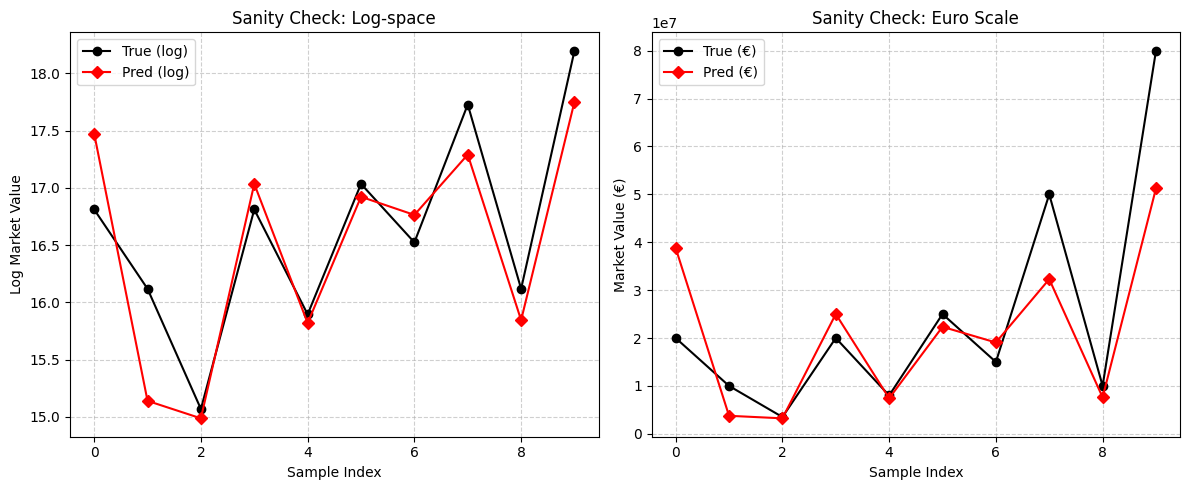

In [82]:
# Sanity Check: Predictions
import matplotlib.pyplot as plt
import numpy as np

# Pick a small random batch of test samples
n_samples = 10
idx = np.random.choice(len(X_test), size=n_samples, replace=False)

y_true_sample = y_test[idx]
y_pred_sample = y_pred_no_att[idx]

# Convert to euro scale
y_true_euro = np.expm1(y_true_sample)
y_pred_euro = np.expm1(y_pred_sample)

print("\nSanity Check (log-space values):")
for i in range(n_samples):
    print(f"Sample {i}: True={y_true_sample[i]:.2f}, Pred={y_pred_sample[i]:.2f}")

print("\nSanity Check (euro scale values):")
for i in range(n_samples):
    print(f"Sample {i}: True=€{y_true_euro[i]:,.0f}, Pred=€{y_pred_euro[i]:,.0f}")

# Plot both
plt.figure(figsize=(12, 5))

# Plot 1: Log-space plot
plt.subplot(1, 2, 1)
plt.plot(range(n_samples), y_true_sample, "ko-", label="True (log)")
plt.plot(range(n_samples), y_pred_sample, "rD-", label="Pred (log)")
plt.xlabel("Sample Index")
plt.ylabel("Log Market Value")
plt.title("Sanity Check: Log-space")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Plot 2: Euro-scale plot
plt.subplot(1, 2, 2)
plt.plot(range(n_samples), y_true_euro, "ko-", label="True (€)")
plt.plot(range(n_samples), y_pred_euro, "rD-", label="Pred (€)")
plt.xlabel("Sample Index")
plt.ylabel("Market Value (€)")
plt.title("Sanity Check: Euro Scale")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## Saving down this improved MUltivariate lstm model and seeking actual euro prediction

In [84]:
# SAVE MODEL
SAVE_DIR = os.path.join(PROJECT_PATH, "Hyperparameter_Tuning")
os.makedirs(SAVE_DIR, exist_ok=True)

no_att_model_path = os.path.join(SAVE_DIR, "Improved_Multivariate_lstm_model.h5")
model_no_att.save(no_att_model_path)

no_att_model_path = os.path.join(SAVE_DIR, "Improved_Multivariate_lstm_model.keras")
model_no_att.save(no_att_model_path)

print(f"\n LSTM model saved to: {no_att_model_path}")



 LSTM model saved to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Hyperparameter_Tuning\Improved_Multivariate_lstm_model.keras


# Hypertuning of Ensemble model

In [17]:
import os, joblib, numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
LSTM_DIR     = os.path.join(PROJECT_PATH, "models", "LSTM_Models")
ENSEMBLE_DIR = os.path.join(PROJECT_PATH, "models", "Ensemble_Model")
save_dir = os.path.join(PROJECT_PATH, "Hyperparameter_Tuning")
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

# Reload splits
X_train = np.load(os.path.join(LSTM_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(LSTM_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(LSTM_DIR, "X_test.npy"))
y_train = np.load(os.path.join(LSTM_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(LSTM_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(LSTM_DIR, "y_test.npy"))

print("Data loaded:", X_train.shape, X_val.shape, X_test.shape)

# Reload LSTM models
custom_objects = {"mse": MeanSquaredError()}
univariate_model    = load_model(os.path.join(LSTM_DIR, "univariate_lstm_model.h5"), custom_objects=custom_objects)
multivariate_model  = load_model(os.path.join(LSTM_DIR, "multivariate_lstm_model.h5"), custom_objects=custom_objects)
encoder_decoder_model = load_model(os.path.join(LSTM_DIR, "encoder_decoder_lstm_model.h5"), custom_objects=custom_objects)

print("All base models loaded successfully!")


Data loaded: (200, 4, 13) (43, 4, 13) (43, 4, 13)


All base models loaded successfully!


In [18]:
def safe_predict(model, X):
    if model is None:
        return None
    return np.asarray(model.predict(X, verbose=0)).squeeze()

# Univariate (reshape input properly)
X_train_uni = np.expand_dims(X_train[:, :-1, 0], axis=-1)
X_val_uni   = np.expand_dims(X_val[:, :-1, 0], axis=-1)
X_test_uni  = np.expand_dims(X_test[:, :-1, 0], axis=-1)

pred_train_uni = safe_predict(univariate_model, X_train_uni)
pred_val_uni   = safe_predict(univariate_model, X_val_uni)
pred_test_uni  = safe_predict(univariate_model, X_test_uni)

# Multivariate
pred_train_multi = safe_predict(multivariate_model, X_train)
pred_val_multi   = safe_predict(multivariate_model, X_val)
pred_test_multi  = safe_predict(multivariate_model, X_test)

# Seq2Seq (2 horizons)
def seq2seq_predict(model, X):
    if model is None:
        return None, None
    p = model.predict(X, verbose=0)  # (n, 2, 1)
    return p[:, 0, 0], p[:, 1, 0]

pred_train_h1, pred_train_h2 = seq2seq_predict(encoder_decoder_model, X_train)
pred_val_h1,   pred_val_h2   = seq2seq_predict(encoder_decoder_model, X_val)
pred_test_h1,  pred_test_h2  = seq2seq_predict(encoder_decoder_model, X_test)

print("Predictions generated!")


Predictions generated!


In [19]:
def build_meta_features(pred_uni, pred_multi, pred_h1, pred_h2):
    feats = []
    if pred_uni is not None:   feats.append(pred_uni.reshape(-1, 1))
    if pred_multi is not None: feats.append(pred_multi.reshape(-1, 1))
    if pred_h1 is not None:    feats.append(pred_h1.reshape(-1, 1))
    if pred_h2 is not None:    feats.append(pred_h2.reshape(-1, 1))
    return np.hstack(feats)

X_meta_train = build_meta_features(pred_train_uni, pred_train_multi, pred_train_h1, pred_train_h2)
X_meta_val   = build_meta_features(pred_val_uni,   pred_val_multi,   pred_val_h1,   pred_val_h2)
X_meta_test  = build_meta_features(pred_test_uni,  pred_test_multi,  pred_test_h1,  pred_test_h2)

print("Meta feature shapes:", X_meta_train.shape, X_meta_val.shape, X_meta_test.shape)


Meta feature shapes: (200, 4) (43, 4) (43, 4)


In [20]:
np.save(os.path.join(save_dir, "X_meta_train.npy"), X_meta_train)
np.save(os.path.join(save_dir, "X_meta_val.npy"),   X_meta_val)
np.save(os.path.join(save_dir, "X_meta_test.npy"),  X_meta_test)

np.save(os.path.join(save_dir, "y_meta_train.npy"), y_train)
np.save(os.path.join(save_dir, "y_meta_val.npy"),   y_val)
np.save(os.path.join(save_dir, "y_meta_test.npy"),  y_test)

print("Meta features saved in:", save_dir)


Meta features saved in: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Hyperparameter_Tuning


In [24]:
# Optuna hyperparameter tuning for XGBoost ensemble
import os, sys, subprocess, joblib, numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# try to import optuna, install if missing
try:
    import optuna
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna

# XGBoost import
try:
    from xgboost import XGBRegressor
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    from xgboost import XGBRegressor

# User paths
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"

candidate_dirs = [
    os.path.join(PROJECT_PATH, "models", "Hyperparam_Tuning"),
    os.path.join(PROJECT_PATH, "Hyperparam_Tuning"),
    os.path.join(PROJECT_PATH, "models", "Ensemble_Model"),
    os.path.join(PROJECT_PATH, "Hyperparameter_Tuning"),
]
ENSEMBLE_DIR = os.path.join(PROJECT_PATH, "models", "Ensemble_Model")
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

# search for the meta npy files
base_dir = None
for d in candidate_dirs:
    if os.path.exists(os.path.join(d, "X_meta_train.npy")):
        base_dir = d
        break
if base_dir is None:
    raise FileNotFoundError("Could not find X_meta_train.npy in candidate dirs. Run the meta-feature creation cell first (saves X_meta_train.npy etc).")

print("Loading meta arrays from:", base_dir)
X_meta_train = np.load(os.path.join(base_dir, "X_meta_train.npy"))
X_meta_val   = np.load(os.path.join(base_dir, "X_meta_val.npy"))
X_meta_test  = np.load(os.path.join(base_dir, "X_meta_test.npy"))

possible_y_names = ["y_meta_train_log.npy", "y_meta_train.npy", "y_train.npy", "y_train_meta.npy"]
y_meta_train = None
y_meta_val = None
y_meta_test = None
for name in possible_y_names:
    p = os.path.join(base_dir, name)
    if os.path.exists(p):
        try:
            y_meta_train = np.load(p)
            break
        except Exception:
            pass
if y_meta_train is None:
    raise FileNotFoundError("Could not find y_meta_train (checked common names).")

# load val/test using similar naming pattern
for name in possible_y_names:
    p = os.path.join(base_dir, name.replace("train", "val"))
    if os.path.exists(p):
        y_meta_val = np.load(p); break
for name in possible_y_names:
    p = os.path.join(base_dir, name.replace("train", "test"))
    if os.path.exists(p):
        y_meta_test = np.load(p); break

# if val/test not found, try y_val.npy / y_test.npy
if y_meta_val is None and os.path.exists(os.path.join(base_dir, "y_val.npy")):
    y_meta_val = np.load(os.path.join(base_dir, "y_val.npy"))
if y_meta_test is None and os.path.exists(os.path.join(base_dir, "y_test.npy")):
    y_meta_test = np.load(os.path.join(base_dir, "y_test.npy"))

# pick first horizon if targets are 2D
def pick_first_horizon(y):
    y = np.asarray(y)
    if y.ndim == 2 and y.shape[1] > 1:
        return y[:, 0]
    return y.ravel()

y_train = pick_first_horizon(y_meta_train)
y_val   = pick_first_horizon(y_meta_val) if y_meta_val is not None else None
y_test  = pick_first_horizon(y_meta_test) if y_meta_test is not None else None

print("Shapes -> X_meta_train, y_train:", X_meta_train.shape, y_train.shape)
if y_val is not None:
    print("Shapes -> X_meta_val, y_val:", X_meta_val.shape, y_val.shape)
if y_test is not None:
    print("Shapes -> X_meta_test, y_test:", X_meta_test.shape, y_test.shape)

# Optuna objective
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)
    # try to use early_stopping_rounds
    try:
        model.fit(
            X_meta_train, y_train,
            eval_set=[(X_meta_val, y_val)],
            early_stopping_rounds=50,
            verbose=False
        )
    except TypeError:
        # old xgboost, fit without early_stopping_rounds
        model.fit(
            X_meta_train, y_train,
            eval_set=[(X_meta_val, y_val)],
            verbose=False
        )

    preds = model.predict(X_meta_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# Run study
study = optuna.create_study(direction="minimize")
N_TRIALS = 30
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\nBest trial params:")
print(study.best_trial.params)

# Retrain best model on train+val
best_params = study.best_trial.params
best_params.update({"objective":"reg:squarederror", "random_state":42, "n_jobs":-1})
final_model = XGBRegressor(**best_params)

# combine train+val to retrain
if y_val is not None:
    X_comb = np.vstack([X_meta_train, X_meta_val])
    y_comb = np.hstack([y_train, y_val])
else:
    X_comb = X_meta_train
    y_comb = y_train

try:
    final_model.fit(X_comb, y_comb, eval_set=[(X_meta_val, y_val)] if y_val is not None else None,
                    early_stopping_rounds=50, verbose=False)
except TypeError:
    final_model.fit(X_comb, y_comb, eval_set=[(X_meta_val, y_val)] if y_val is not None else None, verbose=False)

[I 2025-09-27 14:32:33,972] A new study created in memory with name: no-name-19b6a929-6e19-4e7f-a51b-13ee36d63396


Loading meta arrays from: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Hyperparameter_Tuning
Shapes -> X_meta_train, y_train: (200, 4) (200,)
Shapes -> X_meta_val, y_val: (43, 4) (43,)
Shapes -> X_meta_test, y_test: (43, 4) (43,)


Best trial: 0. Best value: 0.969266:   3%|▎         | 1/30 [00:01<00:34,  1.20s/it]

[I 2025-09-27 14:32:35,475] Trial 0 finished with value: 0.9692662705707076 and parameters: {'n_estimators': 587, 'max_depth': 4, 'learning_rate': 0.003698061436377248, 'subsample': 0.5757638209193707, 'colsample_bytree': 0.9444207607983894, 'min_child_weight': 9, 'gamma': 4.522643911032765, 'reg_alpha': 7.006175117399707e-07, 'reg_lambda': 0.1596482857095171}. Best is trial 0 with value: 0.9692662705707076.


Best trial: 1. Best value: 0.954207:   7%|▋         | 2/30 [00:02<00:34,  1.24s/it]

[I 2025-09-27 14:32:36,836] Trial 1 finished with value: 0.9542066838120262 and parameters: {'n_estimators': 773, 'max_depth': 5, 'learning_rate': 0.1709672684479857, 'subsample': 0.6514176174652587, 'colsample_bytree': 0.6000494280159933, 'min_child_weight': 7, 'gamma': 1.8458039922414948, 'reg_alpha': 7.063675585777104e-07, 'reg_lambda': 1.272119927354864e-07}. Best is trial 1 with value: 0.9542066838120262.


Best trial: 1. Best value: 0.954207:  10%|█         | 3/30 [00:04<00:41,  1.55s/it]

[I 2025-09-27 14:32:38,756] Trial 2 finished with value: 1.0810329474977791 and parameters: {'n_estimators': 495, 'max_depth': 8, 'learning_rate': 0.0027705638776587952, 'subsample': 0.75538245683694, 'colsample_bytree': 0.6522098753634458, 'min_child_weight': 1, 'gamma': 0.57021030407095, 'reg_alpha': 7.829712415185574e-06, 'reg_lambda': 0.009405888763371775}. Best is trial 1 with value: 0.9542066838120262.
[I 2025-09-27 14:32:38,935] Trial 3 finished with value: 1.269262816321241 and parameters: {'n_estimators': 213, 'max_depth': 5, 'learning_rate': 0.00016299614442961337, 'subsample': 0.6821248718209374, 'colsample_bytree': 0.5919419632490475, 'min_child_weight': 9, 'gamma': 0.4316706212669069, 'reg_alpha': 0.0002583753014072795, 'reg_lambda': 3.1275537087719525e-07}. Best is trial 1 with value: 0.9542066838120262.


[I 2025-09-27 14:32:39,030] Trial 4 finished with value: 0.898917089095847 and parameters: {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.16611701743516338, 'subsample': 0.6755988073112481, 'colsample_bytree': 0.6509640501611056, 'min_child_weight': 9, 'gamma': 3.420046663271693, 'reg_alpha': 2.0357532928419734e-07, 'reg_lambda': 2.713445575365307e-06}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  20%|██        | 6/30 [00:04<00:13,  1.84it/s]

[I 2025-09-27 14:32:39,205] Trial 5 finished with value: 0.9206114980557653 and parameters: {'n_estimators': 443, 'max_depth': 5, 'learning_rate': 0.07543923946705475, 'subsample': 0.5105639355554332, 'colsample_bytree': 0.5688094542177096, 'min_child_weight': 6, 'gamma': 3.212764519430065, 'reg_alpha': 4.0167967095449065e-06, 'reg_lambda': 1.6835814439827672e-07}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  23%|██▎       | 7/30 [00:05<00:10,  2.12it/s]

[I 2025-09-27 14:32:39,483] Trial 6 finished with value: 1.2251200621809737 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.00030069717976031313, 'subsample': 0.8787146786295041, 'colsample_bytree': 0.6170947863633252, 'min_child_weight': 10, 'gamma': 2.608648354817849, 'reg_alpha': 6.04556525402852e-08, 'reg_lambda': 0.0015844732706173379}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  30%|███       | 9/30 [00:05<00:06,  3.16it/s]

[I 2025-09-27 14:32:39,705] Trial 7 finished with value: 1.1335677780335316 and parameters: {'n_estimators': 234, 'max_depth': 7, 'learning_rate': 0.001648173235198894, 'subsample': 0.881181713949581, 'colsample_bytree': 0.7717949174155004, 'min_child_weight': 8, 'gamma': 3.541882239611795, 'reg_alpha': 2.2208673894959595e-05, 'reg_lambda': 0.09352587761725487}. Best is trial 4 with value: 0.898917089095847.
[I 2025-09-27 14:32:39,809] Trial 8 finished with value: 0.9422638401110507 and parameters: {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.031453947764426546, 'subsample': 0.8050829987899207, 'colsample_bytree': 0.6033551700975508, 'min_child_weight': 9, 'gamma': 4.623701857740045, 'reg_alpha': 7.28113979070319e-07, 'reg_lambda': 0.001368532996198174}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  33%|███▎      | 10/30 [00:06<00:08,  2.35it/s]

[I 2025-09-27 14:32:40,500] Trial 9 finished with value: 0.9448959842671071 and parameters: {'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.003176178253309636, 'subsample': 0.7715194049730663, 'colsample_bytree': 0.919917357218675, 'min_child_weight': 10, 'gamma': 0.7691961920730661, 'reg_alpha': 0.025749271071538554, 'reg_lambda': 0.0008788101551764219}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  37%|███▋      | 11/30 [00:06<00:10,  1.87it/s]

[I 2025-09-27 14:32:41,302] Trial 10 finished with value: 0.9588243339429027 and parameters: {'n_estimators': 885, 'max_depth': 3, 'learning_rate': 0.021372216430462932, 'subsample': 0.9757961027577253, 'colsample_bytree': 0.7116164893181428, 'min_child_weight': 4, 'gamma': 1.8920817213563548, 'reg_alpha': 5.469815977588944, 'reg_lambda': 1.233859217021939e-05}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  40%|████      | 12/30 [00:08<00:13,  1.34it/s]

[I 2025-09-27 14:32:42,551] Trial 11 finished with value: 0.9711259241819975 and parameters: {'n_estimators': 345, 'max_depth': 5, 'learning_rate': 0.28161609833941936, 'subsample': 0.5069821439750986, 'colsample_bytree': 0.5093779587797083, 'min_child_weight': 5, 'gamma': 3.508061965527477, 'reg_alpha': 1.0330386969365945e-08, 'reg_lambda': 8.432985384350947e-06}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  47%|████▋     | 14/30 [00:08<00:07,  2.03it/s]

[I 2025-09-27 14:32:42,995] Trial 12 finished with value: 0.9348263811654026 and parameters: {'n_estimators': 375, 'max_depth': 4, 'learning_rate': 0.057660750981035666, 'subsample': 0.5098321451274725, 'colsample_bytree': 0.8085967760324967, 'min_child_weight': 6, 'gamma': 3.179436269095749, 'reg_alpha': 0.0013712856298068526, 'reg_lambda': 1.7079731738497585e-08}. Best is trial 4 with value: 0.898917089095847.
[I 2025-09-27 14:32:43,105] Trial 13 finished with value: 0.9293673975383904 and parameters: {'n_estimators': 103, 'max_depth': 6, 'learning_rate': 0.08851817532406399, 'subsample': 0.6282962866595168, 'colsample_bytree': 0.5014057166308208, 'min_child_weight': 2, 'gamma': 4.220036419373461, 'reg_alpha': 4.0017966286450994e-05, 'reg_lambda': 3.538483839483033e-06}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  50%|█████     | 15/30 [00:08<00:06,  2.43it/s]

[I 2025-09-27 14:32:43,325] Trial 14 finished with value: 0.9371271928691703 and parameters: {'n_estimators': 342, 'max_depth': 4, 'learning_rate': 0.017741042379265954, 'subsample': 0.5916873696671195, 'colsample_bytree': 0.6992090817515686, 'min_child_weight': 4, 'gamma': 2.5966759918072118, 'reg_alpha': 8.02730469508138e-08, 'reg_lambda': 3.43600388249634e-05}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  53%|█████▎    | 16/30 [00:09<00:05,  2.65it/s]

[I 2025-09-27 14:32:43,622] Trial 15 finished with value: 0.9386503091930806 and parameters: {'n_estimators': 605, 'max_depth': 6, 'learning_rate': 0.09620488809710588, 'subsample': 0.687028375616089, 'colsample_bytree': 0.836872288425234, 'min_child_weight': 7, 'gamma': 3.8636863418222616, 'reg_alpha': 0.01301491691555345, 'reg_lambda': 5.859367933393649e-07}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  57%|█████▋    | 17/30 [00:09<00:05,  2.39it/s]

[I 2025-09-27 14:32:44,135] Trial 16 finished with value: 0.9340380890519916 and parameters: {'n_estimators': 971, 'max_depth': 4, 'learning_rate': 0.012997796464102625, 'subsample': 0.5680733262484825, 'colsample_bytree': 0.5544720539669499, 'min_child_weight': 6, 'gamma': 1.7456418386281956, 'reg_alpha': 4.863689732260407e-06, 'reg_lambda': 4.93337498923953}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  60%|██████    | 18/30 [00:09<00:04,  2.76it/s]

[I 2025-09-27 14:32:44,371] Trial 17 finished with value: 0.947049202722864 and parameters: {'n_estimators': 402, 'max_depth': 7, 'learning_rate': 0.2962833797839413, 'subsample': 0.7171520939124094, 'colsample_bytree': 0.6897241759798225, 'min_child_weight': 3, 'gamma': 2.935123876457292, 'reg_alpha': 1.076786403550827e-08, 'reg_lambda': 1.9275563239640083e-08}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  63%|██████▎   | 19/30 [00:10<00:03,  3.16it/s]

[I 2025-09-27 14:32:44,578] Trial 18 finished with value: 0.9708015378903968 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.00929318199187248, 'subsample': 0.8243923146356575, 'colsample_bytree': 0.5537148585535053, 'min_child_weight': 7, 'gamma': 4.89633202397469, 'reg_alpha': 0.0005102888183798861, 'reg_lambda': 6.566232283501441e-05}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  67%|██████▋   | 20/30 [00:10<00:03,  3.25it/s]

[I 2025-09-27 14:32:44,863] Trial 19 finished with value: 0.9546059930473734 and parameters: {'n_estimators': 462, 'max_depth': 6, 'learning_rate': 0.04495258240741671, 'subsample': 0.5554150967068899, 'colsample_bytree': 0.6584870426904388, 'min_child_weight': 5, 'gamma': 1.3370102555639292, 'reg_alpha': 1.3188069945244644e-07, 'reg_lambda': 1.3605668233286329e-06}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  73%|███████▎  | 22/30 [00:11<00:02,  3.39it/s]

[I 2025-09-27 14:32:45,340] Trial 20 finished with value: 0.9682046605186634 and parameters: {'n_estimators': 739, 'max_depth': 8, 'learning_rate': 0.13158415698630935, 'subsample': 0.6201736483062904, 'colsample_bytree': 0.7401363025560826, 'min_child_weight': 8, 'gamma': 3.9140031635715467, 'reg_alpha': 6.594378941546955, 'reg_lambda': 5.461336196319535e-08}. Best is trial 4 with value: 0.898917089095847.
[I 2025-09-27 14:32:45,489] Trial 21 finished with value: 0.9357396565133967 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.0781690086936207, 'subsample': 0.640417433451538, 'colsample_bytree': 0.5072112521718821, 'min_child_weight': 1, 'gamma': 4.087275068667497, 'reg_alpha': 3.5707007138335484e-05, 'reg_lambda': 3.237484143744012e-06}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  77%|███████▋  | 23/30 [00:11<00:01,  4.09it/s]

[I 2025-09-27 14:32:45,615] Trial 22 finished with value: 0.9191357156337743 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1463527732074013, 'subsample': 0.7104375417096712, 'colsample_bytree': 0.5576075905132121, 'min_child_weight': 2, 'gamma': 4.286434201558381, 'reg_alpha': 8.412683118913067e-05, 'reg_lambda': 0.00010525721657332777}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  80%|████████  | 24/30 [00:11<00:01,  4.32it/s]

[I 2025-09-27 14:32:45,816] Trial 23 finished with value: 0.9158097327188998 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.18396358164993082, 'subsample': 0.714520068400329, 'colsample_bytree': 0.6553709862373648, 'min_child_weight': 4, 'gamma': 3.212222550276606, 'reg_alpha': 1.908827739343199e-06, 'reg_lambda': 0.00011445779364784965}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  87%|████████▋ | 26/30 [00:11<00:00,  4.47it/s]

[I 2025-09-27 14:32:46,161] Trial 24 finished with value: 1.1954538658302263 and parameters: {'n_estimators': 293, 'max_depth': 4, 'learning_rate': 0.0008308670789637836, 'subsample': 0.7261182825309673, 'colsample_bytree': 0.6478105301519597, 'min_child_weight': 3, 'gamma': 3.50444432895765, 'reg_alpha': 0.00012192199953567801, 'reg_lambda': 0.00014238070173188164}. Best is trial 4 with value: 0.898917089095847.
[I 2025-09-27 14:32:46,286] Trial 25 finished with value: 0.9517027543769895 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.17112249676985586, 'subsample': 0.6929360206818916, 'colsample_bytree': 0.998875814499034, 'min_child_weight': 2, 'gamma': 2.3190663791876975, 'reg_alpha': 0.004153043312827245, 'reg_lambda': 0.00023864649133038812}. Best is trial 4 with value: 0.898917089095847.


[I 2025-09-27 14:32:46,471] Trial 26 finished with value: 0.939244751138577 and parameters: {'n_estimators': 189, 'max_depth': 4, 'learning_rate': 0.03325151907999779, 'subsample': 0.784385036744175, 'colsample_bytree': 0.6628761804495242, 'min_child_weight': 3, 'gamma': 4.441251439205802, 'reg_alpha': 1.4425611546163173e-06, 'reg_lambda': 0.005264350768445645}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  93%|█████████▎| 28/30 [00:12<00:00,  4.89it/s]

[I 2025-09-27 14:32:46,658] Trial 27 finished with value: 0.9177854879173275 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.19535433258743082, 'subsample': 0.8322806942226179, 'colsample_bytree': 0.7351290056512088, 'min_child_weight': 4, 'gamma': 2.9806467779459904, 'reg_alpha': 0.13156070185817184, 'reg_lambda': 3.581175168149612e-05}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917:  97%|█████████▋| 29/30 [00:12<00:00,  4.65it/s]

[I 2025-09-27 14:32:46,899] Trial 28 finished with value: 0.9669316599572486 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.006438680653651232, 'subsample': 0.8577553757378825, 'colsample_bytree': 0.7934642187236822, 'min_child_weight': 4, 'gamma': 2.8963909594814625, 'reg_alpha': 0.5496540752546989, 'reg_lambda': 1.5373722867752032e-05}. Best is trial 4 with value: 0.898917089095847.


Best trial: 4. Best value: 0.898917: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]

[I 2025-09-27 14:32:47,153] Trial 29 finished with value: 0.9109847116221473 and parameters: {'n_estimators': 575, 'max_depth': 6, 'learning_rate': 0.27746082339820466, 'subsample': 0.9474044559017748, 'colsample_bytree': 0.733549066074381, 'min_child_weight': 5, 'gamma': 2.254095977004191, 'reg_alpha': 0.16567920122042823, 'reg_lambda': 0.00961477495661975}. Best is trial 4 with value: 0.898917089095847.

Best trial params:
{'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.16611701743516338, 'subsample': 0.6755988073112481, 'colsample_bytree': 0.6509640501611056, 'min_child_weight': 9, 'gamma': 3.420046663271693, 'reg_alpha': 2.0357532928419734e-07, 'reg_lambda': 2.713445575365307e-06}


In [31]:
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import os

# Best hyperparameters from Optuna
best_params = {
    'n_estimators': 186,
    'max_depth': 5,
    'learning_rate': 0.16611701743516338,
    'subsample': 0.6755988073112481,
    'colsample_bytree': 0.6509640501611056,
    'min_child_weight': 9,
    'gamma': 3.420046663271693,
    'reg_alpha': 2.0357532928419734e-07,
    'reg_lambda': 2.713445575365307e-06
}

# build final model
final_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    **best_params
)

# Train on (train + val)
X_train_full = np.vstack([X_meta_train, X_meta_val])
y_train_full = np.hstack([y_train, y_val])

final_model.fit(X_train_full, y_train_full)

# Evaluate on test set
y_pred_test = final_model.predict(X_meta_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print("\n Final Tuned Ensemble Performance (Test Set):")
print(" RMSE:", round(rmse, 4))
print(" MAE :", round(mae, 4))
print(" R²  :", round(r2, 4))

# Save final tuned ensemble inside Hyperparameter_Tuning
TUNER_SAVE_DIR = os.path.join(PROJECT_PATH, "Hyperparameter_Tuning")
os.makedirs(TUNER_SAVE_DIR, exist_ok=True)

final_path = os.path.join(TUNER_SAVE_DIR, "xgb_ensemble_final.pkl")
joblib.dump(final_model, final_path)

print(f"\n Final Tuned Ensemble model saved to: {final_path}")


 Final Tuned Ensemble Performance (Test Set):
 RMSE: 0.7716
 MAE : 0.6146
 R²  : 0.1444

 Final Tuned Ensemble model saved to: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\Hyperparameter_Tuning\xgb_ensemble_final.pkl


# Comparision between hyper-tunned multivariate attention lstm model and xgb ensemble model


Sanity Check (log-space values):
Sample 0: True=14.51, NoAtt-LSTM=15.28, Ensemble=15.05
Sample 1: True=15.07, NoAtt-LSTM=15.61, Ensemble=14.71
Sample 2: True=16.81, NoAtt-LSTM=16.73, Ensemble=16.10
Sample 3: True=16.52, NoAtt-LSTM=17.24, Ensemble=17.41
Sample 4: True=18.06, NoAtt-LSTM=17.72, Ensemble=18.12
Sample 5: True=16.81, NoAtt-LSTM=17.06, Ensemble=17.66
Sample 6: True=17.50, NoAtt-LSTM=17.00, Ensemble=17.46
Sample 7: True=17.50, NoAtt-LSTM=15.74, Ensemble=16.51
Sample 8: True=17.22, NoAtt-LSTM=16.91, Ensemble=16.58
Sample 9: True=16.81, NoAtt-LSTM=16.63, Ensemble=17.04

Sanity Check (euro scale values):
Sample 0: True=€2,000,000, NoAtt-LSTM=€4,314,736, Ensemble=€3,422,967
Sample 1: True=€3,500,000, NoAtt-LSTM=€6,003,166, Ensemble=€2,439,590
Sample 2: True=€20,000,000, NoAtt-LSTM=€18,362,908, Ensemble=€9,780,073
Sample 3: True=€15,000,000, NoAtt-LSTM=€30,724,884, Ensemble=€36,378,160
Sample 4: True=€70,000,000, NoAtt-LSTM=€49,480,380, Ensemble=€74,347,024
Sample 5: True=€20,000,

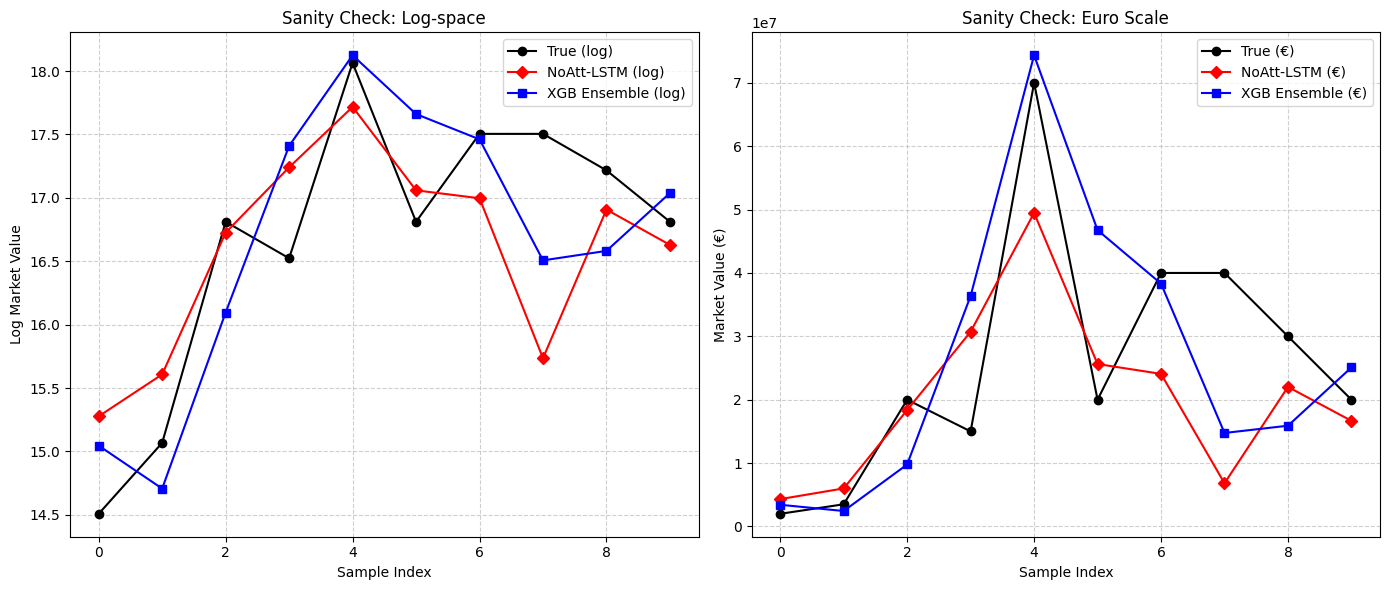

In [50]:
# Sanity Check Predictions on Improved Multivariate LSTM vs XGB Ensemble
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

# Load tuned ensemble
xgb_final = joblib.load(
    os.path.join(PROJECT_PATH, "Hyperparameter_Tuning", "xgb_ensemble_final.pkl")
)

# Ensemble predictions (using meta-features we saved earlier)
X_meta_test = np.load(os.path.join(PROJECT_PATH, "Hyperparameter_Tuning", "X_meta_test.npy"))
y_pred_ens = xgb_final.predict(X_meta_test)

# Pick a small random batch of test samples
n_samples = 10
idx = np.random.choice(len(X_test), size=n_samples, replace=False)

y_true_sample = y_test[idx]            # log-space
y_pred_lstm_sample = y_pred_no_att[idx]
y_pred_ens_sample = y_pred_ens[idx]    # log-space

# Convert to euro scale
y_true_euro = np.expm1(y_true_sample)
y_pred_lstm_euro = np.expm1(y_pred_lstm_sample)
y_pred_ens_euro = np.expm1(y_pred_ens_sample)

print("\nSanity Check (log-space values):")
for i in range(n_samples):
    print(
        f"Sample {i}: True={y_true_sample[i]:.2f}, "
        f"NoAtt-LSTM={y_pred_lstm_sample[i]:.2f}, "
        f"Ensemble={y_pred_ens_sample[i]:.2f}"
    )

print("\nSanity Check (euro scale values):")
for i in range(n_samples):
    print(
        f"Sample {i}: True=€{y_true_euro[i]:,.0f}, "
        f"NoAtt-LSTM=€{y_pred_lstm_euro[i]:,.0f}, "
        f"Ensemble=€{y_pred_ens_euro[i]:,.0f}"
    )

# Plotting
plt.figure(figsize=(14, 6))

# Log-space plot
plt.subplot(1, 2, 1)
plt.plot(range(n_samples), y_true_sample, "ko-", label="True (log)")
plt.plot(range(n_samples), y_pred_lstm_sample, "rD-", label="NoAtt-LSTM (log)")
plt.plot(range(n_samples), y_pred_ens_sample, "bs-", label="XGB Ensemble (log)")
plt.xlabel("Sample Index")
plt.ylabel("Log Market Value")
plt.title("Sanity Check: Log-space")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Euro-scale plot
plt.subplot(1, 2, 2)
plt.plot(range(n_samples), y_true_euro, "ko-", label="True (€)")
plt.plot(range(n_samples), y_pred_lstm_euro, "rD-", label="NoAtt-LSTM (€)")
plt.plot(range(n_samples), y_pred_ens_euro, "bs-", label="XGB Ensemble (€)")
plt.xlabel("Sample Index")
plt.ylabel("Market Value (€)")
plt.title("Sanity Check: Euro Scale")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()